In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
def display_images(images):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis(False)


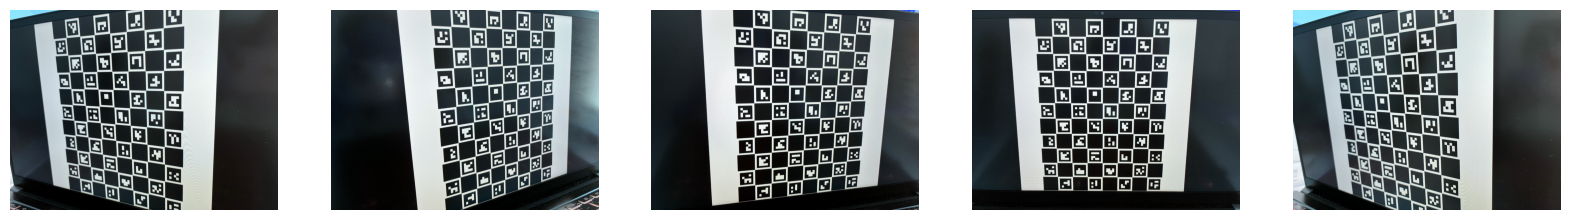

In [6]:
# load images
raw_images = [cv2.imread('../images/imgs_phone/img{}.png'.format(i)) for i in range(1, 6)]
display_images(raw_images)

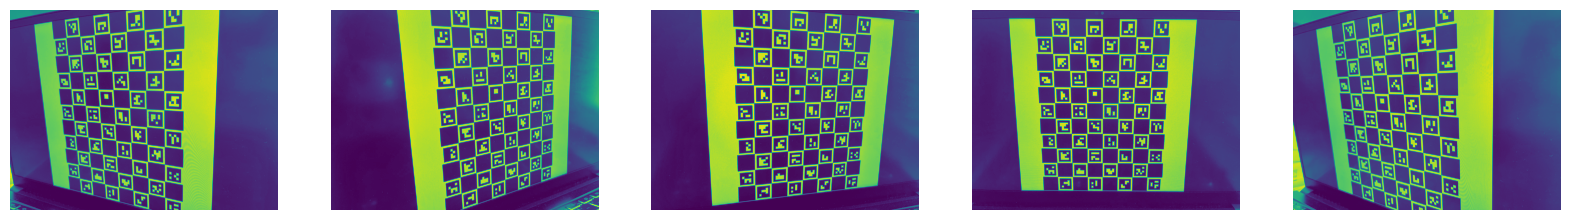

In [7]:
# convert to grayscale
images = [raw_image[:, :, 0] for raw_image in raw_images]
display_images(images)

In [65]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
(squaresX, squaresY) = (8, 11)
objp = np.zeros(((squaresX-1) * (squaresY-1), 3), np.float32)
objp[:, :2] = np.mgrid[0:(squaresX-1), 0:(squaresY-1)].T.reshape(-1,2)
objp.shape

(70, 3)

In [66]:
(squareLength, markerLength) = (48/11, 18.75*48/11/24)
print(f'squareLength = {squareLength} mm')
print(f'markerLength = {markerLength} mm')

squareLength = 4.363636363636363 mm
markerLength = 3.4090909090909087 mm


In [67]:
# create charuco board
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)
board

< cv2.aruco.CharucoBoard 000001FC90CE0750>

In [68]:
detector = cv2.aruco.CharucoDetector(board)
detector

< cv2.aruco.CharucoDetector 000001FC9E6FB8F0>

Image #0: detected 68 corner among 70 corners.
Image #1: detected 64 corner among 70 corners.
Image #2: detected 70 corner among 70 corners.
Image #3: detected 70 corner among 70 corners.
Image #4: detected 53 corner among 70 corners.


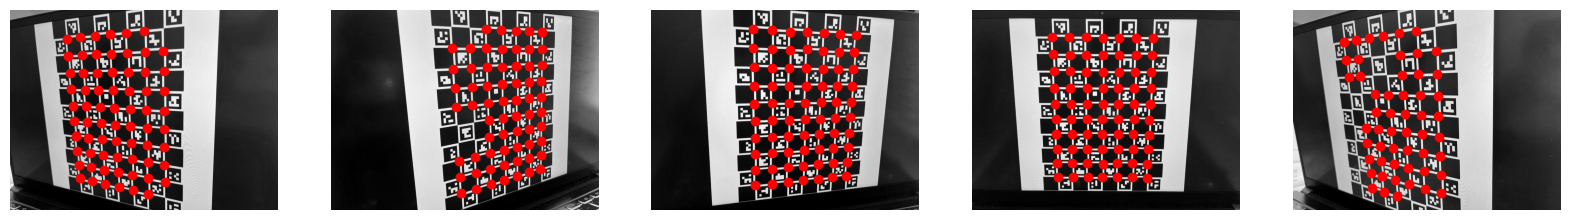

In [78]:
# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

plt.figure(figsize=(20, 10))
# loop over all image paths
for i in range(len(images)):
    gray = images[i]
    
    # find aruco markers
    charuco_corners, charuco_ids, _, _ = detector.detectBoard(gray)
    if len(charuco_corners) == 0:
        continue
    
    # display
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.scatter(charuco_corners[:, 0, 0], charuco_corners[:, 0, 1], color='r')
    plt.axis(False)
    
    if charuco_corners is not None:
        print(f"Image #{i}: detected {len(charuco_corners)} corner among {objp.shape[0]} corners.")

    if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) > 6 and len(charuco_ids) > 6:
        # store object points and image points
        objp_ = objp[charuco_ids]
        # print(objp_.shape, charuco_corners.shape)
        objpoints.append(objp_)
        imgpoints.append(charuco_corners)


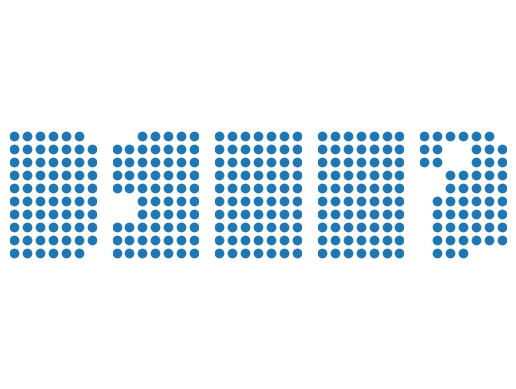

In [70]:
# print the detected corners pattern
for i in range(len(images)):
    pts = objpoints[i]
    plt.subplot(1, len(images), i + 1)
    plt.scatter(pts[:, 0, 0], pts[:, 0, 1])
    plt.axis([min(pts[:, 0, 0]), max(pts[:, 0, 0]), max(pts[:, 0, 1]), min(pts[:, 0, 1])])
    plt.axis('equal')
    plt.axis(False)

In [71]:
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None, flags=(cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_FIX_FOCAL_LENGTH + cv2.CALIB_SAME_FOCAL_LENGTH + cv2.CALIB_ZERO_TANGENT_DIST))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [72]:
ret,mtx, dist

(2.1240801106573794,
 array([[3.16033762e+03, 0.00000000e+00, 2.07020785e+03],
        [0.00000000e+00, 3.16135077e+03, 1.53530199e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 1.73729533e-01, -1.29010213e+00,  7.54405874e-04,
          3.59525877e-04,  2.85294854e+00]]))

In [73]:
rvecs, tvecs

((array([[0.20204036],
         [0.4017879 ],
         [0.01633741]]),
  array([[ 0.16702796],
         [-0.44367272],
         [-0.09044836]]),
  array([[ 0.18819351],
         [-0.23545322],
         [-0.00599062]]),
  array([[ 0.1810052 ],
         [-0.00117282],
         [ 0.00657459]]),
  array([[0.19812977],
         [0.52838755],
         [0.00447569]])),
 (array([[-4.75421329],
         [-4.28939019],
         [12.42894204]]),
  array([[-0.85155954],
         [-4.14788269],
         [10.43359945]]),
  array([[-1.86573606],
         [-4.36120096],
         [11.09912219]]),
  array([[-3.40633989],
         [-4.43312967],
         [12.60244015]]),
  array([[-4.97611752],
         [-4.00938164],
         [12.24136474]])))

Text(0, 0.5, 'error')

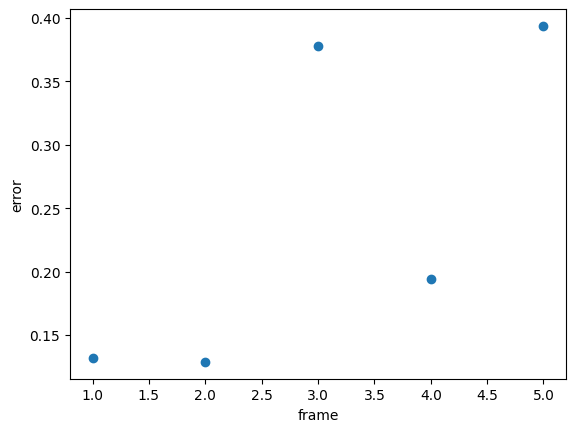

In [79]:
def error_evaluation(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    error_df = pd.DataFrame({'error':[0]})
    for i in range(len(objpoints)):
        # Project object points to image plane
        reprojectedPoints, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        
        img_points = imgpoints
        error = cv2.norm(img_points[i], reprojectedPoints, cv2.NORM_L2) / len(reprojectedPoints)
        new_data = pd.DataFrame({'error':[error]})
        error_df = pd.concat([error_df, new_data], ignore_index=True)
    return error_df
    
error_df = error_evaluation(objpoints, imgpoints,rvecs, tvecs, mtx, dist)[1:]
#error_df
plt.scatter(error_df.index, error_df['error'])
#plt.xlim(0,len(images)+1)
#plt.ylim(0,np.max(error_df['error']))
plt.xlabel('frame')
plt.ylabel('error')

In [75]:
error_df['error']

1    0.132038
2    0.128726
3    0.377509
4    0.193855
5    0.393685
Name: error, dtype: float64

# displaying the calibration performance for individual image

In [44]:
# create charuco board
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


In [46]:
frame = 0
img = images[frame]
gray = img

In [49]:
# find aruco markers
detector = cv2.aruco.CharucoDetector(board)
charuco_corners, charuco_ids, _, _ = detector.detectBoard(gray)
#corners, ids, _ = cv2.aruco.detectMarkers(gray, aruco_dict)
print(len(charuco_corners), len(charuco_ids))

# interpolate charuco corners
#_, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)


if charuco_corners is not None:
    print(f"Detected {len(charuco_corners)}/{len(charuco_ids)}")

    
if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) > 3 and len(charuco_ids) > 3:
    # store object points and image points
    objp_ = objp[charuco_ids]
    # print(objp_.shape, charuco_corners.shape)
    objpoints.append(objp_)
    imgpoints.append(charuco_corners)

print(f"Total: {len(objpoints)}/{len(imgpoints)}")
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

68 68
Detected 68/68
Total: 1/1


In [50]:
for i in range(len(objpoints)):
    # Project object points to image plane
    reprojectedPoints, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)

(-0.5, 4031.5, 3023.5, -0.5)

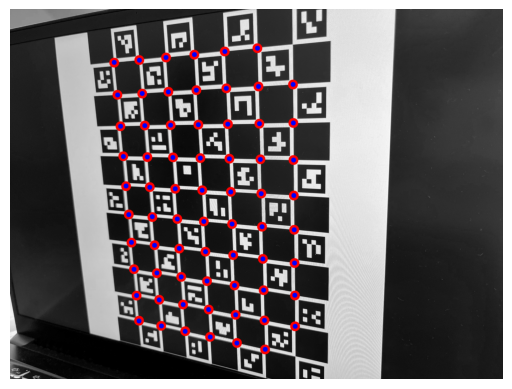

In [56]:
# Add points to the image and draw circles

# draw the paired points in original image
image3 = np.dstack((gray, gray, gray))
for point in imgpoints[0]:
    x,y = point[0]
    cv2.circle(image3, (int(x), int(y)), radius=40, color=(255,0,0), thickness=-1)  # Draw a filled circle around the point
    
# draw the paired points in reprojection image
# dst3 = np.dstack((dst, dst, dst))
for point in reprojectedPoints:
    x,y = point[0]
    cv2.circle(image3, (int(x), int(y)), radius=20, color=(0,0,255), thickness=-1)  # Draw a filled circle around the point
plt.imshow(image3)
plt.axis(False)

In [54]:
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

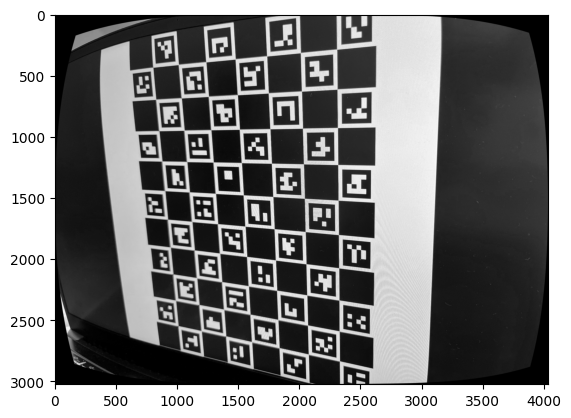

In [55]:
# Undistort an image
image3_o = np.dstack((gray, gray, gray))
dst = cv2.undistort(image3_o, mtx, dist, None, newCameraMatrix=newcameramtx)
plt.imshow(dst,cmap='gray')